The goal of this notebook is to explore how markers can be used to guide the algorithm finding the optimal window within a marker range. This is also useful for looking at marker ranges across an entire graph

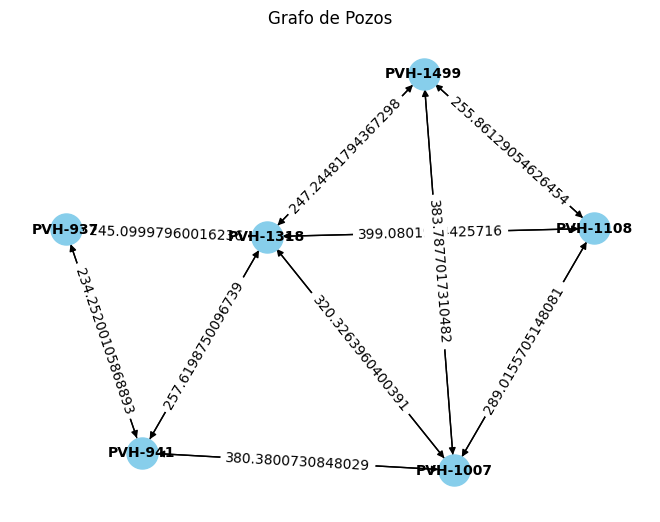

In [1]:
import numpy as np
import pandas as pd
from graph_setup import G
from marker_functions import mkr_calc_window
from calc_functions import calc_tops
from marker_functions import create_subs
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
#marker_ranges = mkr_calc_window(G, "PVH-937", "PVH-941")
#print(marker_ranges)

In [3]:
all_graph_markers = pd.DataFrame()
pd.set_option('display.max_columns', None)

for node in G.nodes:
    mk = G.nodes[node]["markers"]
    graph_markers = pd.DataFrame(columns=["Label", node])
     


    labels = []
    prev_marker = "0"
    for marker in mk["Mkr"]:
        labels.append(f"{prev_marker} - {marker}")
        prev_marker = marker
    labels.append(f"{prev_marker} - inf")

    graph_markers["Label"] = labels

    sub = create_subs(mk["Depth"].tolist())
    graph_markers[node] = sub


    if all_graph_markers.empty:
        all_graph_markers = graph_markers
    else:
        all_graph_markers = pd.merge(all_graph_markers, graph_markers, on="Label", how="outer")

print(all_graph_markers)
    

             Label                 PVH-1007                 PVH-937  \
0            0 - C          (0, 1011.38385)           (0, 969.7597)   
1            C - K  (1011.38385, 1116.2677)   (969.7597, 1075.1807)   
2           K - L2   (1116.2677, 1333.9681)  (1075.1807, 1290.3693)   
3         L2 - inf         (1333.9681, inf)                     NaN   
4   L2 - Top-MEC-C                      NaN  (1290.3693, 1706.3507)   
5  Top-MEC-C - inf                      NaN        (1706.3507, inf)   
6            0 - K                      NaN                     NaN   

                  PVH-941                PVH-1108                PVH-1318  \
0                     NaN          (0, 1008.8733)          (0, 1007.1922)   
1                     NaN  (1008.8733, 1113.1971)  (1007.1922, 1111.3737)   
2  (1073.5878, 1290.3293)  (1113.1971, 1324.5449)  (1111.3737, 1327.1564)   
3        (1290.3293, inf)                     NaN                     NaN   
4                     NaN  (1324.5449, 1770.02

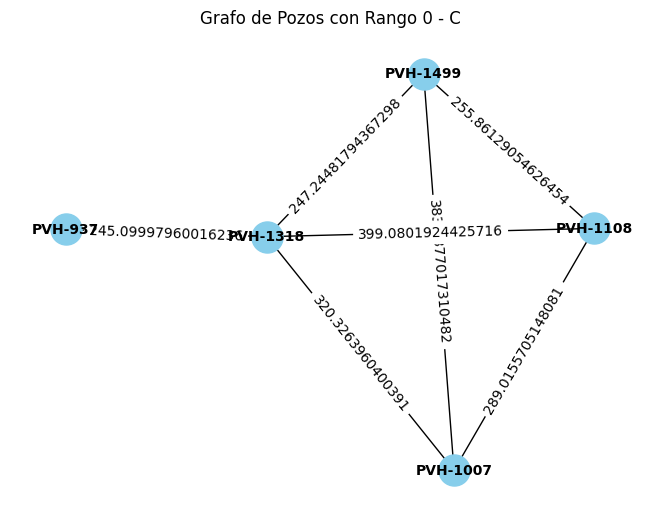

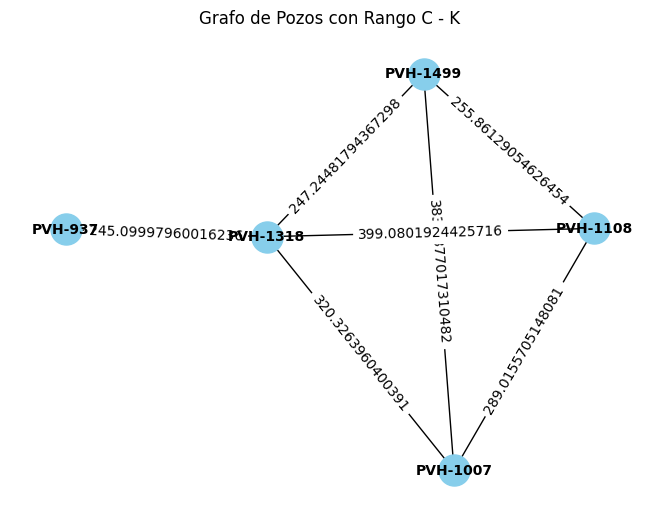

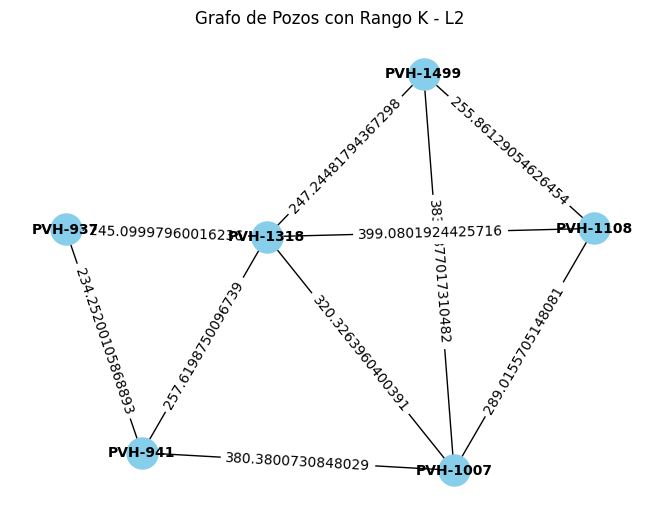

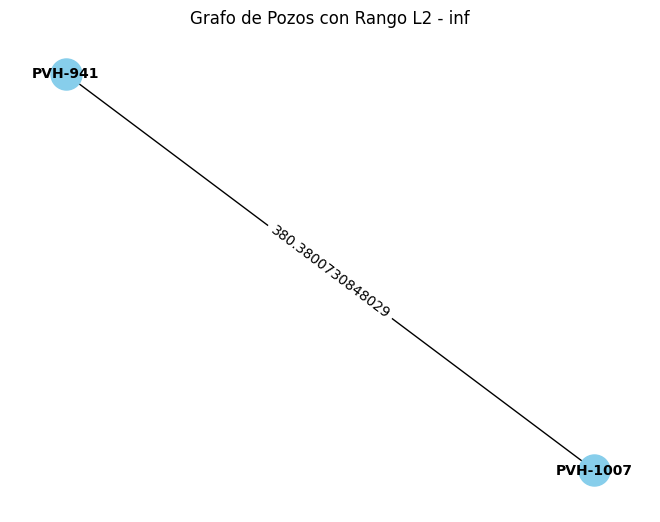

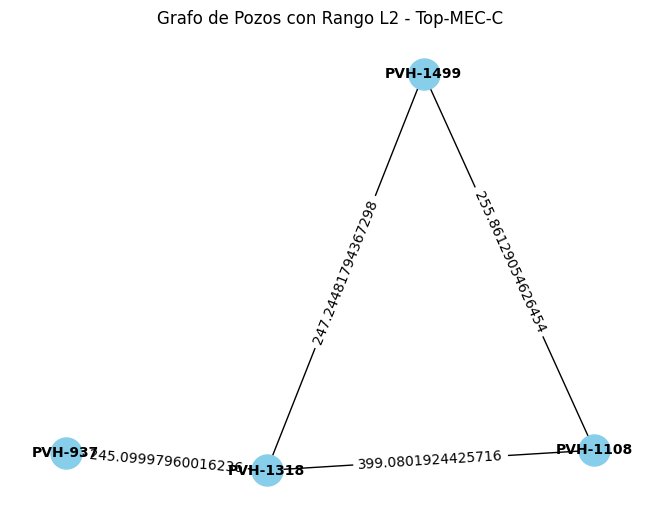

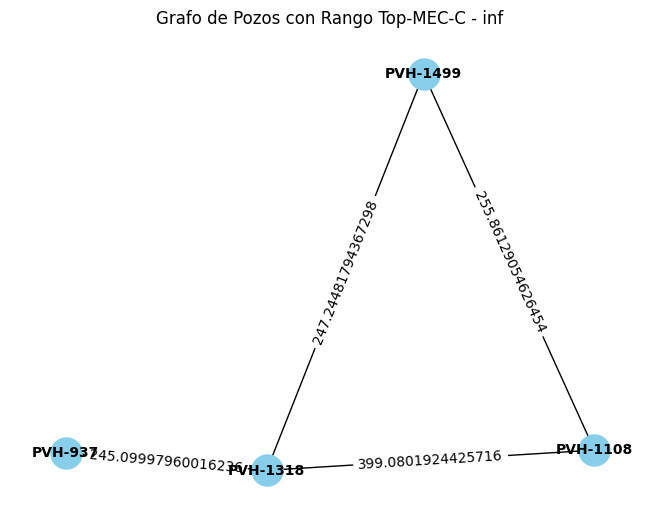

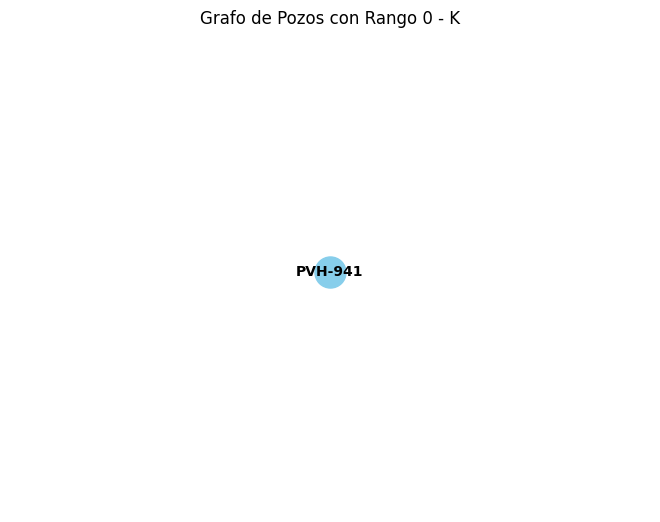

In [4]:
from graph_setup import euclidian_distance

marker_graphs = {}
for _, row in all_graph_markers.iterrows():
    label = row["Label"]
    tempG = nx.Graph()
    
    # Add nodes and edges to the graph for the current row
    for node in G.nodes:
        if node in row.index and pd.notna(row[node]):
            tempG.add_node(node, **G.nodes[node])
            tempG.nodes[node]["data"] = G.nodes[node]["data"]
            tempG.nodes[node]["known_tops"] = G.nodes[node]["known_tops"]
            tempG.nodes[node]["pos"] = G.nodes[node]["pos"]

    marker_graphs[label] = tempG

    threshold_distance = 400
    for node1, data1 in tempG.nodes(data=True):
        for node2, data2 in tempG.nodes(data=True):
            if node1 != node2:
                pos1 = data1['pos']
                pos2 = data2['pos']
                distance = euclidian_distance(pos1[0], pos1[1], pos2[0], pos2[1])
                if distance <= threshold_distance:
                    tempG.add_edge(node1, node2, weight=distance)

    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(tempG, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold')
    labels = nx.get_edge_attributes(tempG, 'weight')
    nx.draw_networkx_edge_labels(tempG, pos, edge_labels=labels)

    plt.title(f"Grafo de Pozos con Rango {label}")
    plt.show() 





In [15]:
from calc_functions import windows_test
for label, graph in marker_graphs.items():
    print(f"Path calculation for range {label}:")

    for e in graph.edges:
        n1, n2 = e 
        w1 = all_graph_markers.loc[all_graph_markers['Label'] == label, n1].values[0]
        w2 = all_graph_markers.loc[all_graph_markers['Label'] == label, n2].values[0]

        w = [w1[0],w1[1],w2[0],w2[1]]

        mae, _ = windows_test(graph, n1, n2, window = w)
        print(f"MAE between {n1} and {n2}: {mae}")
    print()


Path calculation for range 0 - C:
MAE between PVH-1007 and PVH-1108: nan
MAE between PVH-1007 and PVH-1318: nan
MAE between PVH-1007 and PVH-1499: nan
MAE between PVH-937 and PVH-1318: nan
MAE between PVH-1108 and PVH-1318: nan
MAE between PVH-1108 and PVH-1499: nan
MAE between PVH-1318 and PVH-1499: nan

Path calculation for range C - K:
MAE between PVH-1007 and PVH-1108: 4.409633333333318
MAE between PVH-1007 and PVH-1318: 1.6900000000000546
MAE between PVH-1007 and PVH-1499: 1.3166666666666818
MAE between PVH-937 and PVH-1318: 10.964999999999952
MAE between PVH-1108 and PVH-1318: 1.8200000000000158
MAE between PVH-1108 and PVH-1499: 1.7666666666666515
MAE between PVH-1318 and PVH-1499: 0.8

Path calculation for range K - L2:
MAE between PVH-1007 and PVH-941: 5.437499999999986
MAE between PVH-1007 and PVH-1108: 7.966622222222238
MAE between PVH-1007 and PVH-1318: 7.944444444444457
MAE between PVH-1007 and PVH-1499: 9.720899999999986
MAE between PVH-937 and PVH-941: 1.5041666666666818

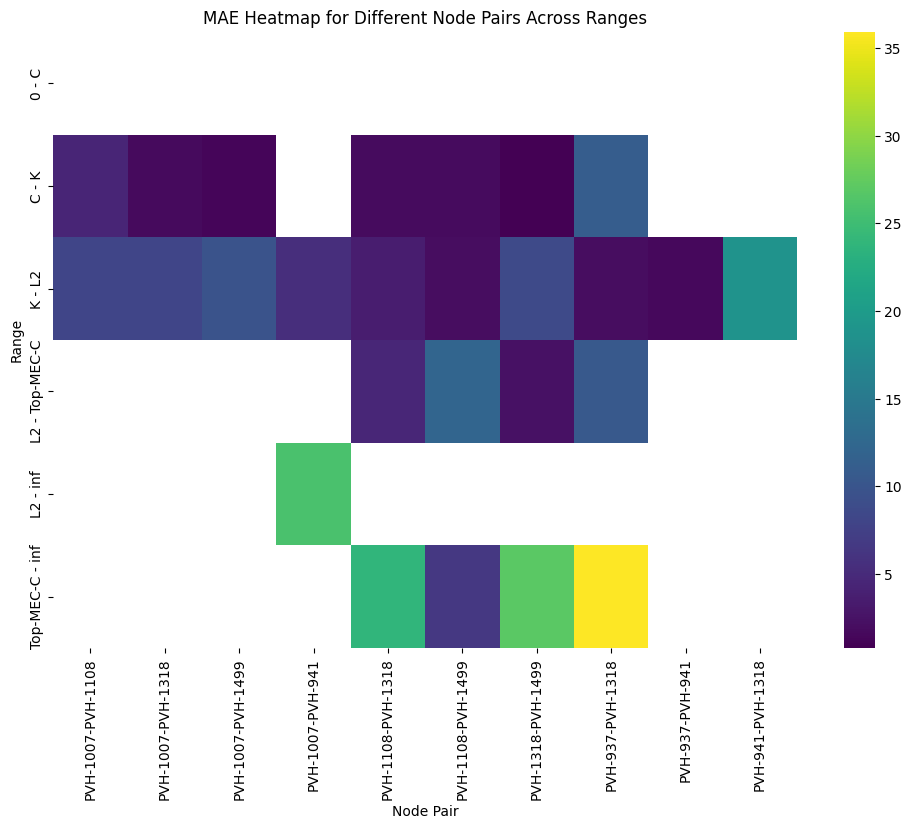

In [16]:
import seaborn as sns

# Prepare data for heatmap
heatmap_data = []
for label, graph in marker_graphs.items():
    for e in graph.edges:
        n1, n2 = e
        w1 = all_graph_markers.loc[all_graph_markers['Label'] == label, n1].values[0]
        w2 = all_graph_markers.loc[all_graph_markers['Label'] == label, n2].values[0]
        w = [w1[0], w1[1], w2[0], w2[1]]
        mae, _ = windows_test(graph, n1, n2, window=w)
        heatmap_data.append([label, f"{n1}-{n2}", mae])

df_heatmap = pd.DataFrame(heatmap_data, columns=["Range", "Node Pair", "MAE"])
df_pivot = df_heatmap.pivot(index="Range", columns="Node Pair", values="MAE")

plt.figure(figsize=(12, 8))
sns.heatmap(df_pivot, annot=True, fmt=".2f", cmap="viridis")
plt.title("MAE Heatmap for Different Node Pairs Across Ranges")
plt.show()


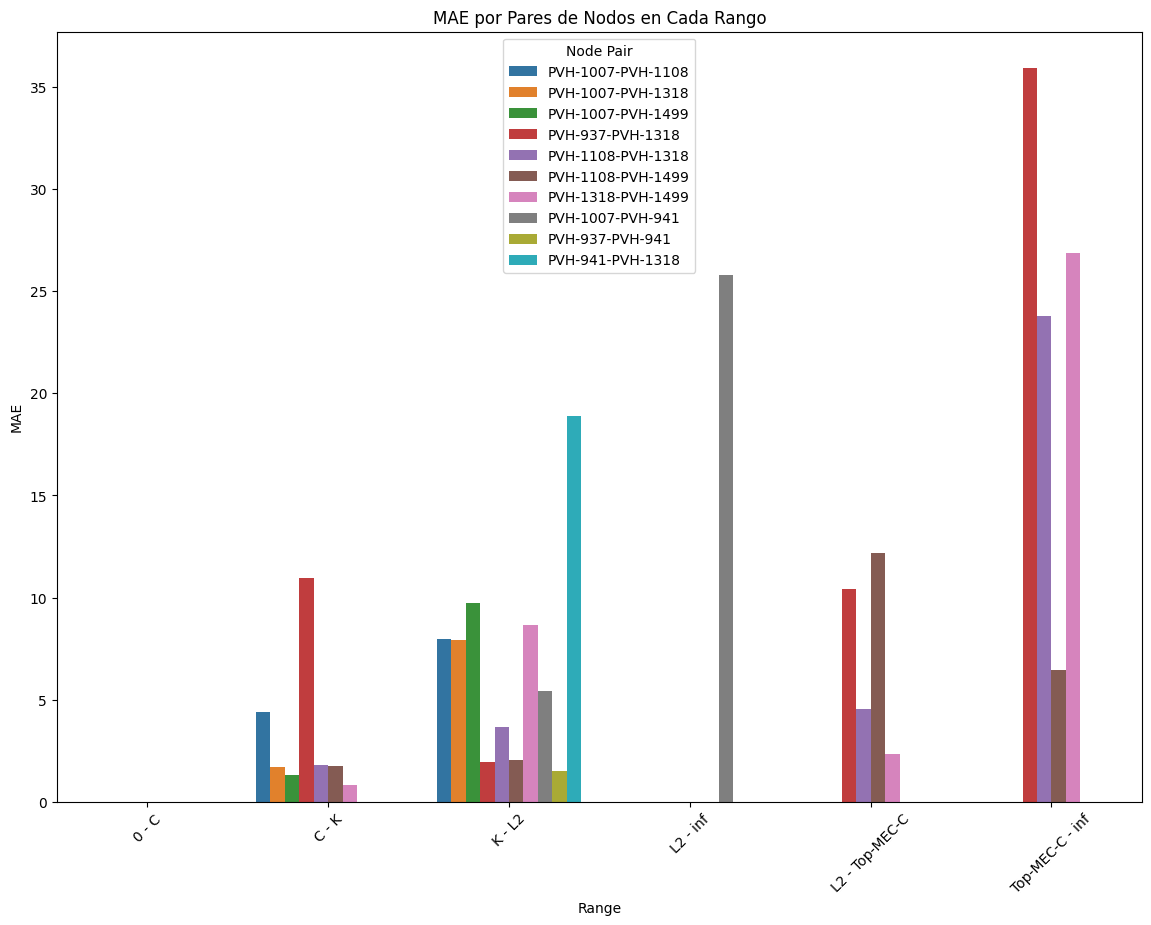

In [13]:

barplot_data = []
for label, graph in marker_graphs.items():
    for e in graph.edges:
        n1, n2 = e
        w1 = all_graph_markers.loc[all_graph_markers['Label'] == label, n1].values[0]
        w2 = all_graph_markers.loc[all_graph_markers['Label'] == label, n2].values[0]
        w = [w1[0], w1[1], w2[0], w2[1]]
        mae, _ = windows_test(graph, n1, n2, window=w)
        barplot_data.append([label, f"{n1}-{n2}", mae])

df_barplot = pd.DataFrame(barplot_data, columns=["Range", "Node Pair", "MAE"])

plt.figure(figsize=(14, 10))
sns.barplot(data=df_barplot, x="Range", y="MAE", hue="Node Pair")
plt.title("MAE por Pares de Nodos en Cada Rango")
plt.xticks(rotation=45)
plt.show()
